In [1]:
from functools import partial
from fvhoe.boundary_conditions import BoundaryCondition
from fvhoe.initial_conditions import double_shock_1d
from fvhoe.solver import EulerSolver
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

warnings.filterwarnings("ignore")

sd_path = "/Users/jonathan/Desktop/sd/"

sys.path.append(sd_path + "src")
sys.path.append(sd_path + "utils")
sys.path.append(sd_path + "ODE")

from sd_simulator import SD_Simulator
from initial_conditions_2d import blast_wave_test

CuPy not available, falling back to NumPy


In [2]:
def sd_plot_1d(ax, sd, param, **kwargs):
    # s.dm.W_cv has shape (nvar,Ny,Nx,n+1,n+1)
    # the function transpose_to_fv reshapes it to (nvar,Ny(n+1),Nx(n+1))
    # which is compatible with visualization
    W = sd.transpose_to_fv(sd.dm.W_cv)
    tr = sd.dm.trouble
    x = sd.dm.x_cv[2:-2]
    var = {"rho": 0, "vx": 1, "P": 3}[param]
    ax.plot(x, W[var][0], **kwargs)

In [3]:
N = 60
p = 3
T = 0.038
gamma = 1.4

In [4]:
# finite volume solvers
fv_solver = EulerSolver(
    w0=partial(double_shock_1d),
    nx=N * (p + 1),
    px=p,
    riemann_solver="hllc",
    bc=BoundaryCondition(
        x={
            "rho": "reflective",
            "E": "reflective",
            "mx": "negative-reflective",
            "my": "periodic",
            "mz": "periodic",
        }
    ),
    gamma=gamma,
    a_posteriori_slope_limiting=True,
    density_floor=True,
    pressure_floor=True,
    slope_limiter="minmod",
)
fv_solver.rkorder(T)

100%|██████████| 0.038/0.038 [01:46]                 


In [5]:
# spectral difference solver
sd_solver = SD_Simulator(
    n=p + 1,
    Nx=N,
    Ny=1,
    init_fct=blast_wave_test,
    BC=["reflex", "periodic"],
    gamma=gamma,
    detect_troubles=True,
    PAD=True,
    convex_combo=True,
    use_cupy=False,
)

sd_solver.perform_time_evolution(T)

1985 time steps (t = 0.038, Execution time: 82.966297 s)15586307452310433, min p = 18.389024948012008)79)


t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50
t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50
t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50


Text(0.5, 0, '$x$')

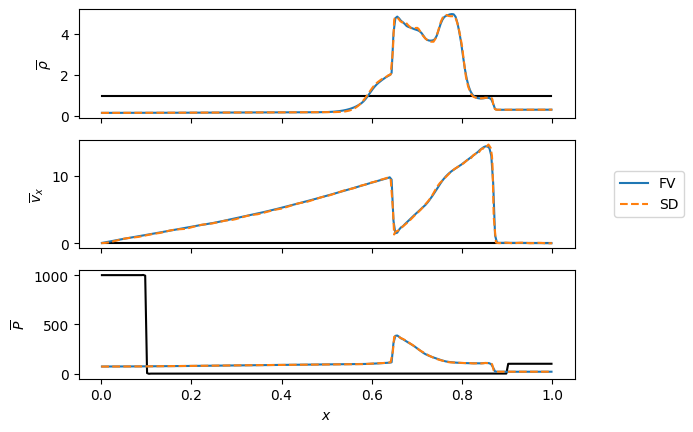

In [6]:
fig, ax = plt.subplots(3, sharex=True)

for i, (var, label) in enumerate(
    zip(
        ["rho", "vx", "P"],
        [r"$\overline{\rho}$", r"$\overline{v}_x$", r"$\overline{P}$"],
    )
):
    fv_solver.plot_1d_slice(ax[i], t=0, color="k", param=var, y=0.5, z=0.5)
    fv_solver.plot_1d_slice(ax[i], t=T, param=var, y=0.5, z=0.5, label="FV")
    sd_plot_1d(ax[i], sd_solver, param=var, linestyle="--", label="SD")
    ax[i].set_ylabel(label)

ax[1].legend(loc="center", bbox_to_anchor=(1.15, 0.5))
ax[2].set_xlabel("$x$")